# Examen TNS 2021-2022

## Evaluation
Vous serez évalué par groupe de 3 (à l'exception d'un groupe 4) lors d'une soutenance orale de 10 min lors de laquelle vous présenterez vos travaux. La présentation se fera en détaillant le notebook. La note sera principalement basée sur votre capacité à restituer de façon claire les notions de cours. Il est donc essentiel d'introduire dans le notebook la logique de votre travail.
La présentation se fait à trois voix et sera suivi q'une séance de questions.

les notebooks devront être transmis par e-mail 2 jours avant la restitution orale

Les données devront mettre en oeuvre des traitements relatifs au cours TNS (donc essentiellement sur des signaux et non des méthodes de traitement d'image)

## Description de l'examen
L'examen a pour but de traiter un radargramme c'est-à-dire les données acquises par un géoradar.

Le géoradar est composé d’un châssis équipé de deux ou quatre roues sur lequel est posé en son centre l’antenne émettrice ('E') et l’antenne réceptrice ('R') très proches du sol. Il dispose également d’un odomètre qui positionne spatialement les réflexions enregistrées sous forme de signal 1D.

<img src="img/Georadar.PNG" style="height:200px">

Le géoradar émet une onde électromagnétique dans le sol sous forme de brèves impulsions à intervalle
régulier. La forme de l’impulsion émise ressemble à une ondelette de Ricker. Lorsque l’onde rencontre une discontinuité, qui se traduit par une différence de permittivité diélectrique entre deux milieux, une partie de l’énergie est réfléchie et une autre transmise. L’ensemble des ondes réfléchies parvenant jusqu’à l’antenne réceptrice est enregistré en fonction du temps.
À chaque impulsion émise, une réponse que l’on appelle trace (ou A-Scan), est stockée sous forme de signal monodimensionnel. L’opérateur, en déplaçant le géoradar va collecter un ensemble de traces qui formeront un radargramme (ou B-Scan)

<img src="img/fonctionnement_georadar2.PNG" style="height:350px">

## Les données
Pour le radargramme traité, les signaux sont enregistrés pendant 62 ns et la longueur de déplacement est de 13 m.

 ### Clutter
La configuration d’antenne avec l’émetteur et le récepteur à la fois très proche l’un de l’autre et très proche du sol implique qu’un premier enregistrement survient très rapidement, appelé onde directe. L’onde directe est très peu atténuée et par conséquent le signal enregistré a une très forte amplitude. De plus, la multiple-réverbération de l’onde avec la surface fait apparaître des formes très horizontales en arrière-plan qui se répètent verticalement sur le radargramme, appelé ringing en anglais.

### Bruit
Le bruit provient de perturbations aléatoires issues des appareils de mesures. Du fait de la très large bande passante de l’antenne, le bruit peut également apparaitre à la suite de l’enregistrement des signaux provenant des ondes électromagnétiques
dans l’air issues des antennes de radio-transmission et des appareils téléphoniques. Dans ce dernier cas des artefacts en forme de colonne apparaissent sur les données. Le bruit apparait essentiellement en fin d’enregistrement d’une trace en l’absence d’information et rehaussé par le gain appliqué en profondeur.

<img src="img/artefacts.PNG" style="height:200px">

In [34]:
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import signal

In [2]:
gprdata = scipy.io.loadmat('DZT_GDF001.mat')

bs = gprdata['radarDZT']
bs = bs.astype(np.int32)

Text(0.5, 0, 'ns')

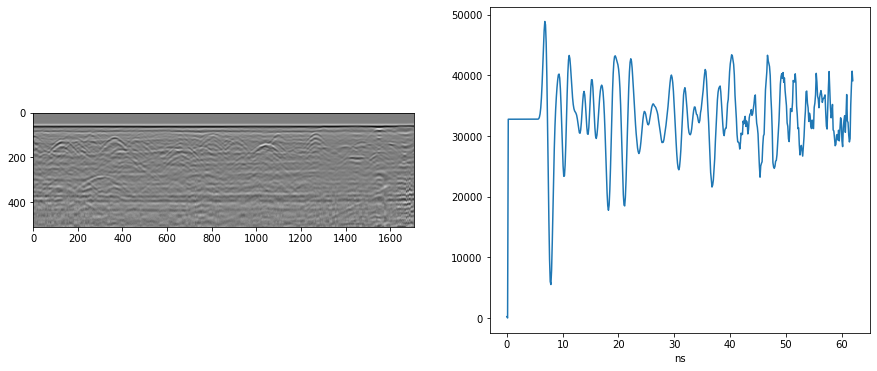

In [3]:
# Chargement d'un radargramme
x = bs[:,100]
t = np.linspace(0, 62, x.size) # ecoute pendant 62 ns
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(bs, 'gray') # illustration du radargramme
plt.subplot(122)
plt.plot(t, x) # chaque colonne du radargramme correspond à un signal
plt.xlabel('ns')

In [4]:
def plot_radargram(bs, name):
    plt.figure(figsize=(15, 6))
    plt.imshow(bs, cmap="gray")
    plt.title(name)
    plt.show()

## Analyse spectrale
A faire selon l'axe temporel et l'axe spatial en 1D

In [5]:
print(bs.shape)

(512, 1705)


In [6]:
fourier = np.array([np.abs(np.fft.rfft(bs[:, i])) for i in range(bs.shape[1])])
print(fourier.shape)

(1705, 257)


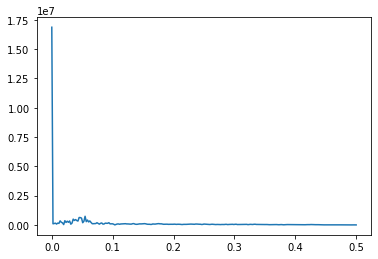

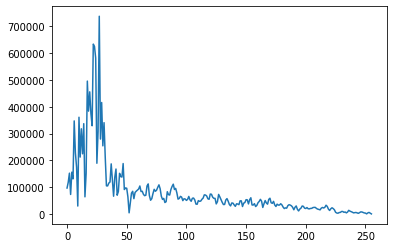

In [7]:
plt.plot(np.fft.rfftfreq(bs.shape[0]), fourier[100])
plt.show()

plt.plot(fourier[100][1:])
plt.show()

## Analyse spectrale spatiale

In [74]:
def spatial_spectrum(signal, sample_rate, index_sample):
    spatial_samples = signal
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("The " + str(index_sample) + "th sample at differents spatial emplacements")
    plt.plot(spatial_samples)

    plt.subplot(1,2,2)
    fourier_spatial = np.fft.rfft(spatial_samples)
    freq = np.fft.rfftfreq(signal.size, d=1./sample_rate)
    plt.title("The spatial spectrum at the " + str(index_sample) + "th sample")
    plt.plot(freq[1:], np.abs(fourier_spatial[1:]))
    plt.show()

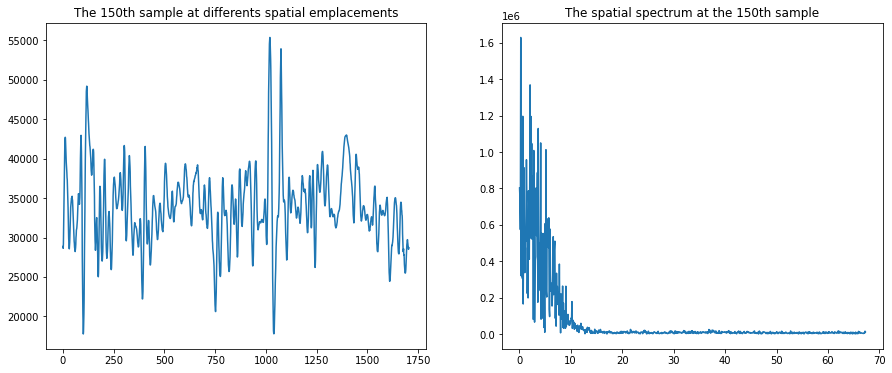

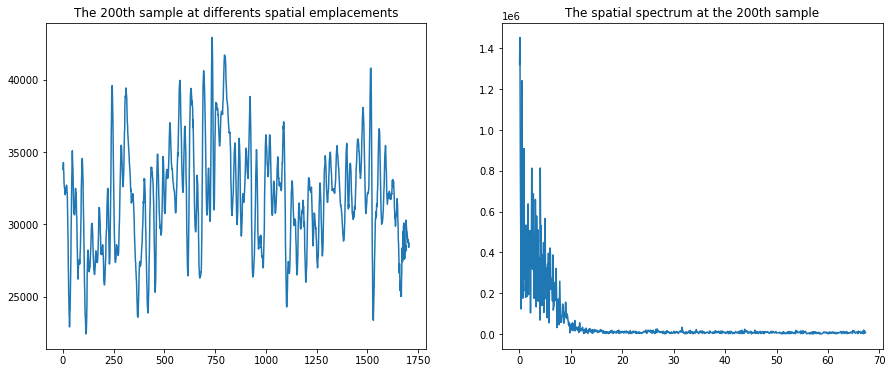

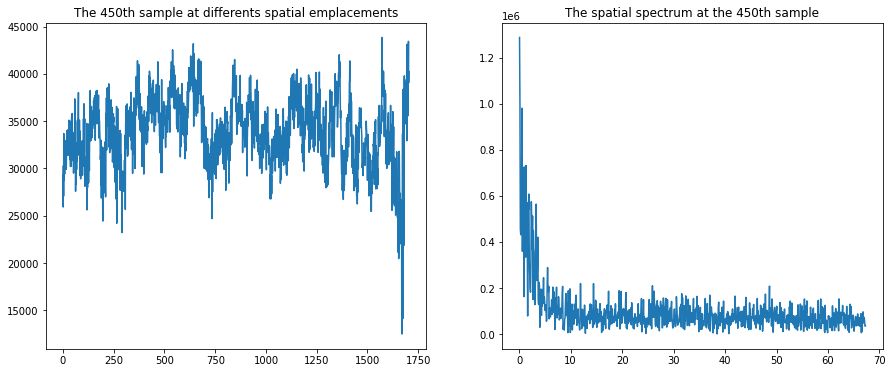

In [89]:
sample_rate = 1750/13 # The gpr moves 13 meters in total with 1750 samples

spatial_spectrum(bs[150], sample_rate, 150)
spatial_spectrum(bs[200], sample_rate, 200)
spatial_spectrum(bs[450], sample_rate, 450)

On peut voir que dans les zones où il y a une majorité d'information que l'on veut conserver, les fréquences en m^-1 convergent vers 0 aux alentours de 10-20 m^-1.

Au contraire, dans les zones où il y a du clutter avec des traits horizontaux, l'analyse spectrale révèle que le spectre ne converge pas vers 0 comme dans les spectres précédents. On peut faire la supposition que ces hautes fréquences correspondent au phénomène de clutter et que nous pouvons les retirer grâce à un filtre passe-bas.

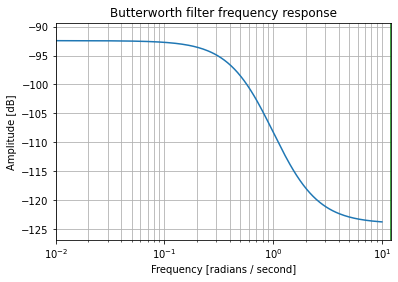

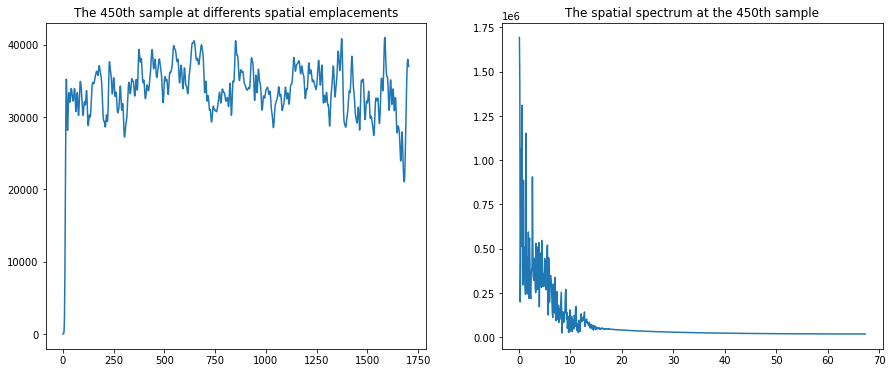

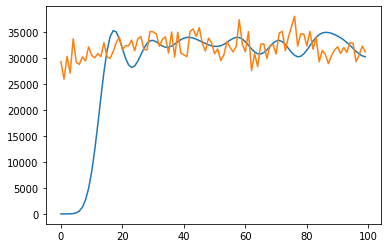

In [94]:
cutoff_freq = 12
b, a = signal.butter(10, cutoff_freq, 'lp', analog=False, fs=sample_rate)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_freq, color='green') # cutoff frequency
plt.show()


sos = signal.butter(10, cutoff_freq, 'lp', fs=sample_rate, output='sos')
filtered = signal.sosfilt(sos, bs[450])
spatial_spectrum(filtered, sample_rate, 450)

plt.plot(filtered[:100])
plt.plot(bs[450][:100])
plt.show()

In [100]:
def filter_by_butterworth(radargram, cutoff_freq, sample_rate, filter_type):
    sos = signal.butter(10, cutoff_freq, filter_type, fs=sample_rate, output='sos')
    return signal.sosfilt(sos, radargram)

(512, 1705)


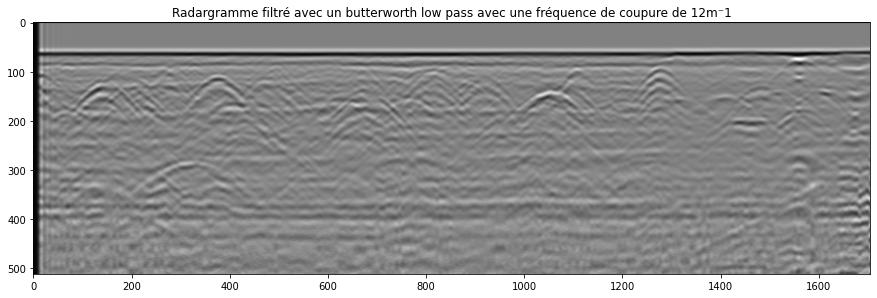

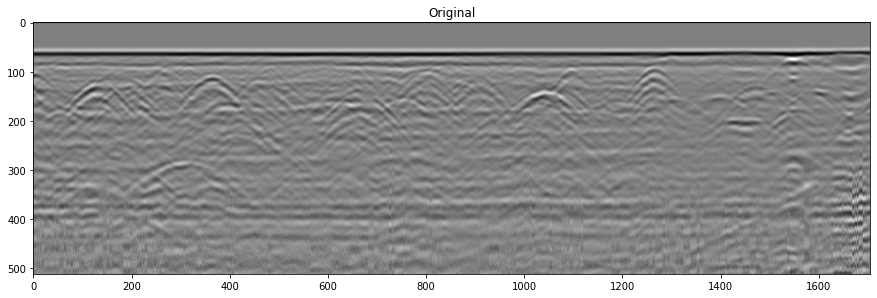

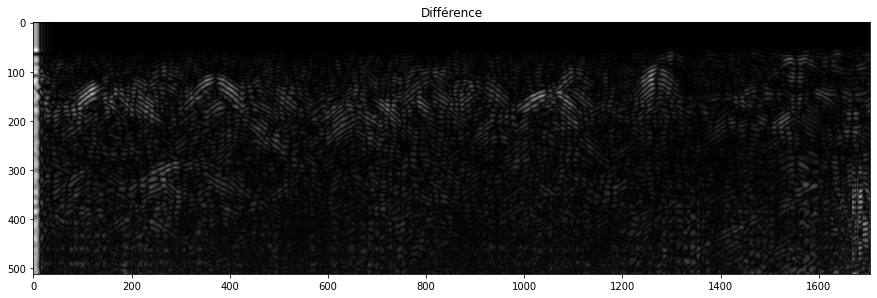

In [101]:
bs_butterworthed = filter_by_butterworth(bs, cutoff_freq, sample_rate, 'lp')
print(bs_butterworthed.shape)
plot_radargram(bs_butterworthed, "Radargramme filtré avec un butterworth low pass avec une fréquence de coupure de " + str(cutoff_freq) + "m⁻1")
plot_radargram(bs, "Original")
plot_radargram(np.abs(bs - bs_butterworthed), "Différence")

## Traitement des données

### Filtrage de l'onde directe et du ringing: Suppression de l'arrière plan

(512,)


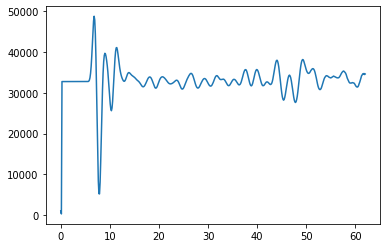

In [8]:
mean = np.mean(bs, axis=1)
print(mean.shape)

plt.plot(t, mean)
plt.show()

(512, 1705)


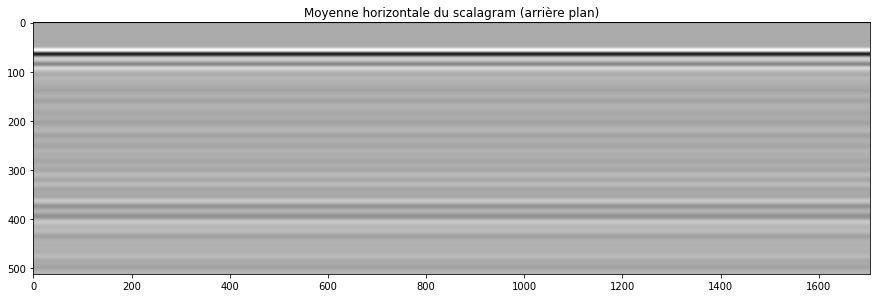

In [9]:
bs_mean = np.repeat(np.expand_dims(mean, axis=-1), bs.shape[1], axis=1)
print(bs_mean.shape)

plot_radargram(bs_mean, "Moyenne horizontale du scalagram (arrière plan)")

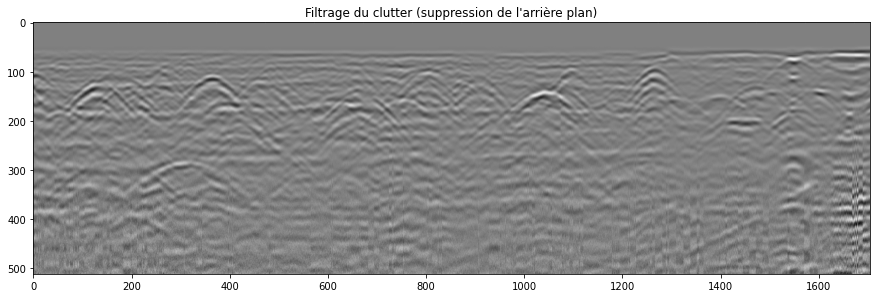

In [14]:
bs_without_mean = bs - bs_mean
plot_radargram(bs_without_mean, "Filtrage du clutter (suppression de l'arrière plan)")

### Filtrage du bruit (artefacts en colonnes): Filtre coupe-haut

In [11]:
bs_filtered = np.array([ndimage.uniform_filter(bs[:, i], size=5) for i in range(bs.shape[1])]).T
print(bs_filtered.shape)

(512, 1705)


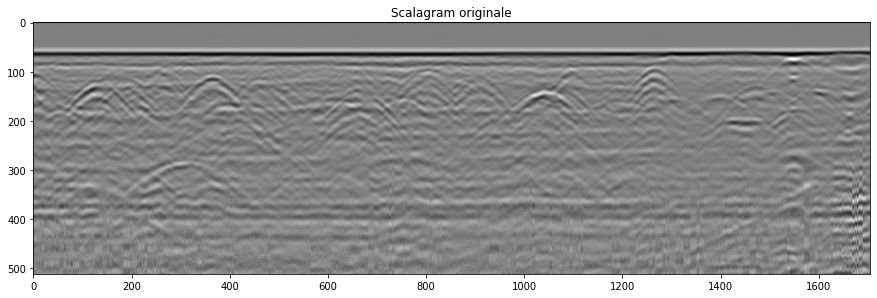

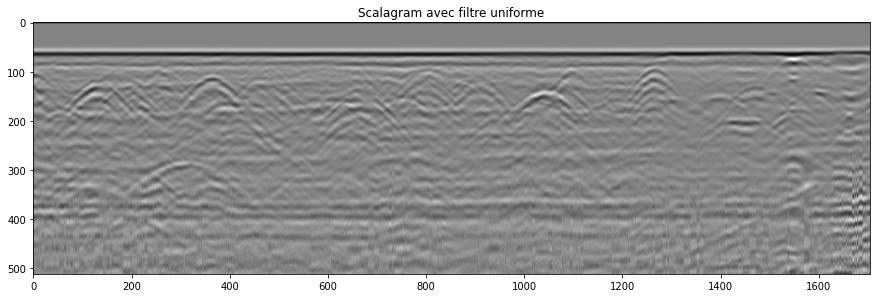

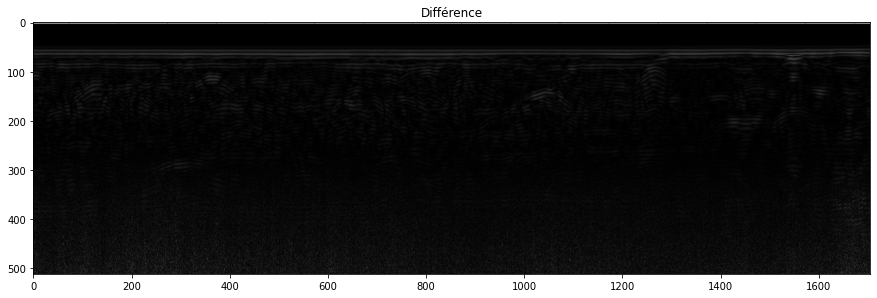

In [12]:
plot_radargram(bs, "Scalagram originale")
plot_radargram(bs_filtered, "Scalagram avec filtre uniforme")

plot_radargram(np.abs(bs - bs_filtered), "Différence")

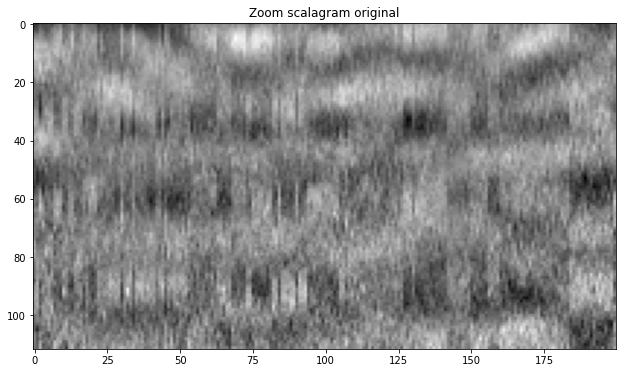

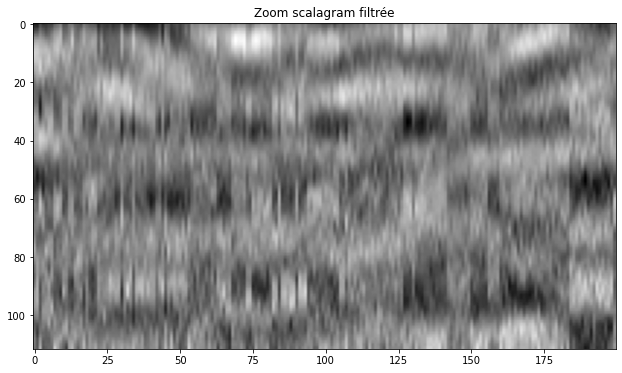

In [13]:
plot_radargram(bs[400:, :200], "Zoom scalagram original")
plot_radargram(bs_filtered[400:, :200], "Zoom scalagram filtrée")